In [1]:
%matplotlib inline
%load_ext Cython


import numpy as np
import math
import os
import matplotlib
import matplotlib.pyplot as plt
import librosa as lb
import librosa.display as lbd
import IPython.display as ipd
import scipy.signal as ss
import scipy.spatial as sspat
import scipy.fft as sfft
import warnings
import pickle as pkl
import time
import itertools

In [2]:
%cd ../
import CythonDTW
import TSM_Import

/mnt/c/Users/Daniel Yang/Desktop/Final_Project
The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [3]:
hop_length = 512

In [4]:
fileId_path = "experiments/fileIds.pkl"
queryInfo_path = "experiments/queryInfo.pkl"
timeData_path = "experiments/timeData.pkl"
audioFiles_path = "experiments/audioFiles.pkl"
with open(fileId_path, 'rb') as f:
    fileIds=pkl.load(f)
with open(queryInfo_path, 'rb') as f:
    queryInfo=pkl.load(f)
with open(timeData_path, 'rb') as f:
    timeData=pkl.load(f)
with open(audioFiles_path, 'rb') as f:
    audioFiles=pkl.load(f)

In [5]:
sr = 22050

In [6]:
def getChromaFeatures(audio):
    chroma = lb.feature.chroma_stft(audio, norm=2)
    return chroma

In [7]:
def getCostMatrix(query, ref):
    return sspat.distance.cdist(query.T, ref.T, metric='cosine')

In [8]:
def inverse_time_function(wp):
    wp = wp*512
    output = np.zeros((wp[-1,0])+1)
    for pair_index in range(len(wp)-1):
        x_0 = wp[pair_index,0]
        x_1 = wp[pair_index+1,0]
        y_0 = wp[pair_index,1]
        y_1 = wp[pair_index+1,1]
        slope = (y_1-y_0)/(x_1-x_0)
        array = y_0+np.arange(x_1-x_0)*slope
        output[x_0:x_1] =array.astype(int)
    output[-1] = wp[-1,1]
    return output

In [9]:
def tf_preprocessing(local_paths):
    ls = []
    for seg in local_paths:
        new_seg = []
        for pair in seg:
            new_seg.append(np.array([pair[0],pair[1]]))
        ls.append(np.array(new_seg))
    return ls
def seg_time_function(wp):
    start_time  = time.time()
    wp = wp*hop_length
    output = np.zeros((wp[-1,1]-wp[0,1])+1)
    x_b = wp[0,1]
    for pair_index in range(len(wp)-1):
        y_0 = wp[pair_index,0]
        y_1 = wp[pair_index+1,0]
        x_0 = wp[pair_index,1]
        x_1 = wp[pair_index+1,1]
        slope = (y_1-y_0)/(x_1-x_0)
        array = y_0+np.arange(x_1-x_0)*slope
        output[x_0-x_b:x_1-x_b] = array
    output[-1] = wp[-1,0]

    return output
def group_time_function(wp,ref_audio_len):
    wp = tf_preprocessing(wp)
    start_time = time.time()

    output = np.zeros(ref_audio_len)
    

    current_start = 0
    for index, seg_path in enumerate(wp):

        pre_padd_end = seg_path[0][1] * hop_length

        output[current_start:pre_padd_end]=(np.arange(pre_padd_end-current_start)+1)+output[current_start-1]

        current_start = pre_padd_end
        tf = seg_time_function(seg_path)
        if index > 0:
            start_point = max(0,wp[index-1][-1][1]-wp[index][0][1])*hop_length
            end_point = min(len(output)-current_start,len(tf))

            tf = tf[start_point:end_point]

        if len(tf)>=2:
            output[current_start:current_start+len(tf)] = tf+tf[1]+output[current_start-1]
        elif len(tf)==1:
            output[current_start:current_start+len(tf)] = tf+output[current_start-1]
        current_start = current_start+len(tf)

    output[current_start:]=np.arange(ref_audio_len-current_start)+output[current_start-1]
    return output

In [10]:
def get_piece():
    solo_piece = [[] for i in range(4)]
    orch_piece = [[] for i in range(4)]
    for j in timeData:
        if j[2]=="s":
            solo_piece[int(j[1])-1].append(j)
        else:
            orch_piece[int(j[1])-1].append(j)
    return orch_piece, solo_piece

In [39]:
def realTimeDTW(C, steps, weights, est_curr_frame):
    # set params
    assert len(steps) % 2 == 0, "The length of steps must be even."
    dn = np.array(steps[::2], dtype=np.uint32)
    dm = np.array(steps[1::2], dtype=np.uint32)
    dw = weights
    subsequence = True
    parameter = {'dn': dn, 'dm': dm, 'dw': dw, 'SubSequence': subsequence}

    # DTW
    [D, s] = DTW_Cost_To_AccumCostAndSteps(C, parameter, est_curr_frame)
    [wp, endCol, endCost] = DTW_GetPath(D, s, parameter)

    # Reformat the output
    wp = wp.T[::-1]
    return wp
#     '''
#     Find the optimal subsequence path through cost matrix C.
    
#     Arguments:
#     C -- cost matrix of dimension (# query frames, # reference frames)
#     steps -- a numpy matrix specifying the allowable transitions.  It should be of
#             dimension (L, 2), where each row specifies (row step, col step)
#     weights -- a vector of size L specifying the multiplicative weights associated 
#                 with each of the allowable transitions
                
#     Returns:
#     optcost -- the optimal subsequence path score
#     path -- a matrix with 2 columns specifying the optimal subsequence path.  Each row 
#             specifies the (row, col) coordinate.
#     '''
#     D = np.full(C.shape, np.inf)
#     B = np.zeros((C.shape[0],C.shape[1],2))
#     est_curr_frame = max(min(est_curr_frame,D.shape[1]),0)
#     lower_bound = max(est_curr_frame-51,0)
#     upper_bound = min(est_curr_frame+100,D.shape[1])
#     ### START CODE BLOCK ###
#     inf = float("inf")
#     D[0,:lower_bound]=.5*np.arange(lower_bound,0,-1)
#     D[0,upper_bound:]=.5*np.arange(D.shape[1]-upper_bound)
#     D[0,lower_bound:upper_bound] = 0
#     for i in range(1,D.shape[0]):
#         for j in range(0,D.shape[1]):
#             opt=[inf for i in range(len(steps))]
#             for index, s in enumerate(steps):
#                 if i-s[0] >= 0 and j-s[1]>=0 and D[i-s[0],j-s[1]]!=np.inf:
#                     previousCell = D[i-s[0],j-s[1]]
#                     opt[index] = previousCell +C[i,j]*weights[index]
#             optimal = min(opt)
#             opt_index = np.argmin(np.array(opt))
#             D[i][j]=optimal
#             B[i][j][0]=steps[opt_index][0]
#             B[i][j][1]=steps[opt_index][1]
            
#     return D, B
    
#     ### END CODE BLOCK ###


# # In[ ]:


# def realTimeBacktrace(D, B, c, steps):
#     '''
#     Backtraces through the cumulative cost matrix D.
    
#     Arguments:
#     D -- cumulative cost matrix
#     B -- backtrace matrix
#     steps -- a numpy matrix specifying the allowable transitions.  It should be of
#             dimension (L, 2), where each row specifies (row step, col step)
    
#     Returns:
#     path -- a python list of (row, col) coordinates for the optimal path.
#     '''

#     path = []

#     ### START CODE BLOCK ###

#     r = B.shape[0]-1
#     path = []
#     while r!=0:
#         path.append((r,c))
#         step = B[r,c]
#         r = int(np.round(r - step[0]))
#         c = int(np.round(c - step[1]))
        
#     path.append((r,c))
    
#     ### END CODE BLOCK ###
    
#     return path


In [12]:
def realTimeDTW1(C, steps, weights, est_curr_frame):
    '''
    Find the optimal subsequence path through cost matrix C.
    
    Arguments:
    C -- cost matrix of dimension (# query frames, # reference frames)
    steps -- a numpy matrix specifying the allowable transitions.  It should be of
            dimension (L, 2), where each row specifies (row step, col step)
    weights -- a vector of size L specifying the multiplicative weights associated 
                with each of the allowable transitions
                
    Returns:
    optcost -- the optimal subsequence path score
    path -- a matrix with 2 columns specifying the optimal subsequence path.  Each row 
            specifies the (row, col) coordinate.
    '''
    D = np.full(C.shape, np.inf)
    B = np.zeros((C.shape[0],C.shape[1],2))
    est_curr_frame = max(min(est_curr_frame,D.shape[1]),0)
    lower_bound = max(est_curr_frame-51,0)
    upper_bound = min(est_curr_frame+100,D.shape[1])
    ### START CODE BLOCK ###
    inf = float("inf")
    D[0,:lower_bound]=.5*np.arange(lower_bound,0,-1)
    D[0,upper_bound:]=.5*np.arange(D.shape[1]-upper_bound)
    D[0,lower_bound:upper_bound] = 0
    for i in range(1,D.shape[0]):
        for j in range(0,D.shape[1]):
            opt=[inf for i in range(len(steps))]
            for index, s in enumerate(steps):
                if i-s[0] >= 0 and j-s[1]>=0 and D[i-s[0],j-s[1]]!=np.inf:
                    previousCell = D[i-s[0],j-s[1]]
                    opt[index] = previousCell +C[i,j]*weights[index]
            optimal = min(opt)
            opt_index = np.argmin(np.array(opt))
            D[i][j]=optimal
            B[i][j][0]=steps[opt_index][0]
            B[i][j][1]=steps[opt_index][1]
            
    return D, B
    
    ### END CODE BLOCK ###


# In[ ]:


def realTimeBacktrace1(D, B, c, steps):
    '''
    Backtraces through the cumulative cost matrix D.
    
    Arguments:
    D -- cumulative cost matrix
    B -- backtrace matrix
    steps -- a numpy matrix specifying the allowable transitions.  It should be of
            dimension (L, 2), where each row specifies (row step, col step)
    
    Returns:
    path -- a python list of (row, col) coordinates for the optimal path.
    '''

    path = []

    ### START CODE BLOCK ###

    r = B.shape[0]-1
    path = []
    while r!=0:
        path.append((r,c))
        step = B[r,c]
        r = int(np.round(r - step[0]))
        c = int(np.round(c - step[1]))
        
    path.append((r,c))
    
    ### END CODE BLOCK ###
    
    return path


In [33]:
%%cython
import numpy as np
cimport numpy as np
cimport cython

import sys
import time


DTYPE_INT32 = np.int32
ctypedef np.int32_t DTYPE_INT32_t

DTYPE_FLOAT = np.float64
ctypedef np.float64_t DTYPE_FLOAT_t

cdef DTYPE_FLOAT_t MAX_FLOAT = float('inf')

# careful, without bounds checking can mess up memory - also can't use negative indices I think (like x[-1])
@cython.boundscheck(False) # turn off bounds-checking for entire function
def DTW_Cost_To_AccumCostAndSteps(Cin, parameter, int est_curr_frame):
    '''
    Inputs
        C: The cost Matrix
    '''


    '''
    Section for checking and catching errors in the inputs
    '''

    cdef np.ndarray[DTYPE_FLOAT_t, ndim=2] C
    try:
        C = np.array(Cin, dtype=DTYPE_FLOAT)
    except TypeError:
        print(bcolors.FAIL + "FAILURE: The type of the cost matrix is wrong - please pass in a 2-d numpy array" + bcolors.ENDC)
        return [-1, -1, -1]
    except ValueError:
        print(bcolors.FAIL + "FAILURE: The type of the elements in the cost matrix is wrong - please have each element be a float (perhaps you passed in a matrix of ints?)" + bcolors.ENDC)
        return [-1, -1, -1]

    cdef np.ndarray[np.uint32_t, ndim=1] dn
    cdef np.ndarray[np.uint32_t, ndim=1] dm
    cdef np.ndarray[DTYPE_FLOAT_t, ndim=1] dw
    # make sure dn, dm, and dw are setup
    # dn loading and exception handling
    if ('dn'  in parameter.keys()):
        try:

            dn = np.array(parameter['dn'], dtype=np.uint32)
        except TypeError:
            print(bcolors.FAIL + "FAILURE: The type of dn (row steps) is wrong - please pass in a 1-d numpy array that holds uint32s" + bcolors.ENDC)
            return [-1, -1, -1]
        except ValueError:
            print(bcolors.FAIL + "The type of the elements in dn (row steps) is wrong - please have each element be a uint32 (perhaps you passed a long?). You can specify this when making a numpy array like: np.array([1,2,3],dtype=np.uint32)" + bcolors.ENDC)
            return [-1, -1, -1]
    else:
        dn = np.array([1, 1, 0], dtype=np.uint32)
    # dm loading and exception handling
    if 'dm'  in parameter.keys():
        try:
            dm = np.array(parameter['dm'], dtype=np.uint32)
        except TypeError:
            print(bcolors.FAIL + "FAILURE: The type of dm (col steps) is wrong - please pass in a 1-d numpy array that holds uint32s" + bcolors.ENDC)
            return [-1, -1, -1]
        except ValueError:
            print(bcolors.FAIL + "FAILURE: The type of the elements in dm (col steps) is wrong - please have each element be a uint32 (perhaps you passed a long?). You can specify this when making a numpy array like: np.array([1,2,3],dtype=np.uint32)" + bcolors.ENDC)
            return [-1, -1, -1]
    else:
        print(bcolors.FAIL + "dm (col steps) was not passed in (gave default value [1,0,1]) " + bcolors.ENDC)
        dm = np.array([1, 0, 1], dtype=np.uint32)
    # dw loading and exception handling
    if 'dw'  in parameter.keys():
        try:
            dw = np.array(parameter['dw'], dtype=DTYPE_FLOAT)
        except TypeError:
            print(bcolors.FAIL + "FAILURE: The type of dw (step weights) is wrong - please pass in a 1-d numpy array that holds floats" + bcolors.ENDC)
            return [-1, -1, -1]
        except ValueError:
            print(bcolors.FAIL + "FAILURE:The type of the elements in dw (step weights) is wrong - please have each element be a float (perhaps you passed ints or a long?). You can specify this when making a numpy array like: np.array([1,2,3],dtype=np.float64)" + bcolors.ENDC)
            return [-1, -1, -1]
    else:
        dw = np.array([1, 1, 1], dtype=DTYPE_FLOAT)
        print(bcolors.FAIL + "dw (step weights) was not passed in (gave default value [1,1,1]) " + bcolors.ENDC)

    
    '''
    Section where types are given to the variables we're going to use 
    '''
    # create matrices to store our results (D and E)
    cdef DTYPE_INT32_t numRows = C.shape[0] # only works with np arrays, use np.shape(x) will work on lists? want to force to use np though?
    cdef DTYPE_INT32_t est_curr_frame1 = est_curr_frame
    cdef DTYPE_INT32_t numCols = C.shape[1]
    cdef DTYPE_INT32_t numDifSteps = np.size(dw)

    cdef unsigned int maxRowStep = max(dn)
    cdef unsigned int maxColStep = max(dm)

    cdef np.ndarray[np.uint32_t, ndim=2] steps = np.zeros((numRows,numCols), dtype=np.uint32)
    cdef np.ndarray[DTYPE_FLOAT_t, ndim=2] accumCost = np.ones((maxRowStep + numRows, maxColStep + numCols), dtype=DTYPE_FLOAT) * MAX_FLOAT

    cdef DTYPE_FLOAT_t bestCost
    cdef DTYPE_INT32_t bestCostIndex
    cdef DTYPE_FLOAT_t costForStep
    cdef unsigned int row, col
    cdef unsigned int stepIndex

    '''
    The start of the actual algorithm, now that all our variables are set up
    '''
    # initializing the cost matrix - depends on whether its subsequence DTW
    # essentially allow us to hop on the bottom anywhere (so could start partway through one of the signals)
    if parameter['SubSequence']:
        est_curr_frame1 = max(min(est_curr_frame1, numCols),0)
        lower_bound = max(est_curr_frame1-51,0)
        upper_bound = min(est_curr_frame1+100,numCols)
        ### START CODE BLOCK ###
        inf = float("inf")
        accumCost[maxRowStep,maxColStep:maxColStep+lower_bound]=.5*np.arange(lower_bound,0,-1)
        accumCost[maxRowStep,maxColStep+upper_bound:]=.5*np.arange(numCols-upper_bound)
        accumCost[maxRowStep,maxColStep+lower_bound:maxColStep+upper_bound] = 0
    else:
        accumCost[maxRowStep, maxColStep] = C[0,0]
        

    # filling the accumulated cost matrix
    for row in range(maxRowStep, numRows + maxRowStep, 1):
        for col in range(maxColStep, numCols + maxColStep, 1):
            bestCost = accumCost[<unsigned int>row, <unsigned int>col] # initialize with what's there - so if is an entry point, then can start low
            bestCostIndex = 0
            # go through each step, find the best one
            for stepIndex in range(numDifSteps):
                #costForStep = accumCost[<unsigned int>(row - dn[<unsigned int>(stepIndex)]), <unsigned int>(col - dm[<unsigned int>(stepIndex)])] + dw[<unsigned int>(stepIndex)] * C[<unsigned int>(row - maxRowStep), <unsigned int>(col - maxColStep)]
                costForStep = accumCost[<unsigned int>((row - dn[(stepIndex)])), <unsigned int>((col - dm[(stepIndex)]))] + dw[stepIndex] * C[<unsigned int>(row - maxRowStep), <unsigned int>(col - maxColStep)]
                if costForStep < bestCost:
                    bestCost = costForStep
                    bestCostIndex = stepIndex
            # save the best cost and best cost index
            accumCost[row, col] = bestCost
            steps[<unsigned int>(row - maxRowStep), <unsigned int>(col - maxColStep)] = bestCostIndex

    # return the accumulated cost along with the matrix of steps taken to achieve that cost
    return [accumCost[maxRowStep:, maxColStep:], steps]

@cython.boundscheck(False) # turn off bounds-checking for entire function
def DTW_GetPath(np.ndarray[DTYPE_FLOAT_t, ndim=2] accumCost, np.ndarray[np.uint32_t, ndim=2] stepsForCost, parameter):
    '''

    Parameter should have: 'dn', 'dm', 'dw', 'SubSequence'
    '''

    cdef np.ndarray[unsigned int, ndim=1] dn
    cdef np.ndarray[unsigned int, ndim=1] dm
    cdef np.uint8_t subseq
    # make sure dn, dm, and dw are setup
    if ('dn'  in parameter.keys()):
        dn = parameter['dn']
    else:
        dn = np.array([1, 1, 0], dtype=DTYPE_INT32)
    if 'dm'  in parameter.keys():
        dm = parameter['dm']
    else:
        dm = np.array([1, 0, 1], dtype=DTYPE_INT32)
    if 'SubSequence' in parameter.keys():
        subseq = parameter['SubSequence']
    else:
        subseq = 0

    cdef np.uint32_t numRows
    cdef np.uint32_t numCols
    cdef np.uint32_t curRow
    cdef np.uint32_t curCol
    cdef np.uint32_t endCol
    cdef DTYPE_FLOAT_t endCost

    numRows = accumCost.shape[0]
    numCols = accumCost.shape[1]

    # either start at the far corner (non sub-sequence)
    # or start at the lowest cost entry in the last row (sub-sequence)
    # where all of the signal along the row has been used, but only a 
    # sub-sequence of the signal along the columns has to be used
    curRow = numRows - 1
    if subseq:
        curCol = np.argmin(accumCost[numRows - 1, :])
    else:
        curCol = numCols - 1

    endCol = curCol
    endCost = accumCost[curRow, curCol]

    cdef np.uint32_t curRowStep
    cdef np.uint32_t curColStep
    cdef np.uint32_t curStepIndex


    cdef np.ndarray[np.uint32_t, ndim=2] path = np.zeros((2, numRows + numCols), dtype=np.uint32) # make as large as could need, then chop at the end
    path[0, 0] = curRow
    path[1, 0] = curCol

    cdef np.uint32_t stepsInPath = 1 # starts at one, we add in one before looping
    cdef np.uint32_t stepIndex = 0
    cdef np.int8_t done = (subseq and curRow == 0) or (curRow == 0 and curCol == 0)
    while not done:
        if accumCost[curRow, curCol] == MAX_FLOAT:
            print('A path is not possible')
            break

        # you're done if you've made it to the bottom left (non sub-sequence)
        # or just the bottom (sub-sequence)
        # find the step size
        curStepIndex = stepsForCost[curRow, curCol]
        curRowStep = dn[curStepIndex]
        curColStep = dm[curStepIndex]
        # backtrack by 1 step
        curRow = curRow - curRowStep
        curCol = curCol - curColStep
        # add your new location onto the path
        path[0, stepsInPath] = curRow
        path[1, stepsInPath] = curCol
        stepsInPath = stepsInPath + 1
        # check to see if you're done
        done = (subseq and curRow == 0) or (curRow == 0 and curCol == 0)

    # reverse the path (a matrix with two rows) and return it
    return [np.fliplr(path[:, 0:stepsInPath]), endCol, endCost]

class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

In [34]:
    #
    query_length = 3
    assignment = []
    count = 0
    time_signature = [2,4,4,4]
    orch_piece, solo_piece  = get_piece()
    for piece_id in range(len(orch_piece)):
        
        segment_info = queryInfo['p'+str(piece_id+1)+'s']
        segment = []
        for raw_seg in segment_info:
            start, end = raw_seg[1:raw_seg.index(",")], raw_seg[raw_seg.index(",")+1:-1]
            segment.append([start,end])
        
        for segment_id in range(len(segment)):
            start, end = segment[segment_id]
            
            query_list = []
            query_index = start
            #print(end)
            while query_index != end:
                #print(query_index)
                query_list.append(query_index)
                measure = int(query_index[:query_index.index('.')])
                beat = int(query_index[query_index.index('.')+1:])
                if beat == time_signature[piece_id]:
                    beat = 1
                    measure+=1
                    query_index = str(measure)+"."+str(beat)
                else:
                    beat+=1
                    query_index = str(measure)+"."+str(beat)
                query_list.append(query_index)
                
            for orch_id,solo_id in itertools.product(orch_piece[piece_id],solo_piece[piece_id]):
                
                
                assignment.append([piece_id,segment_id,orch_id,solo_id])
                for query_index in range(len(query_list)//query_length):
                    count+=1

In [35]:
count,assignment[50:]

(15303,
 [[0, 2, 'p1f_perf16', 'p1s_perf12'],
  [0, 2, 'p1f_perf16', 'p1s_perf2'],
  [0, 2, 'p1f_perf16', 'p1s_perf25'],
  [0, 2, 'p1f_perf16', 'p1s_perf3'],
  [0, 2, 'p1f_perf16', 'p1s_perf9'],
  [0, 2, 'p1f_perf2', 'p1s_perf12'],
  [0, 2, 'p1f_perf2', 'p1s_perf2'],
  [0, 2, 'p1f_perf2', 'p1s_perf25'],
  [0, 2, 'p1f_perf2', 'p1s_perf3'],
  [0, 2, 'p1f_perf2', 'p1s_perf9'],
  [0, 2, 'p1f_perf23', 'p1s_perf12'],
  [0, 2, 'p1f_perf23', 'p1s_perf2'],
  [0, 2, 'p1f_perf23', 'p1s_perf25'],
  [0, 2, 'p1f_perf23', 'p1s_perf3'],
  [0, 2, 'p1f_perf23', 'p1s_perf9'],
  [0, 2, 'p1f_perf24', 'p1s_perf12'],
  [0, 2, 'p1f_perf24', 'p1s_perf2'],
  [0, 2, 'p1f_perf24', 'p1s_perf25'],
  [0, 2, 'p1f_perf24', 'p1s_perf3'],
  [0, 2, 'p1f_perf24', 'p1s_perf9'],
  [0, 2, 'p1f_perf6', 'p1s_perf12'],
  [0, 2, 'p1f_perf6', 'p1s_perf2'],
  [0, 2, 'p1f_perf6', 'p1s_perf25'],
  [0, 2, 'p1f_perf6', 'p1s_perf3'],
  [0, 2, 'p1f_perf6', 'p1s_perf9'],
  [0, 3, 'p1f_perf16', 'p1s_perf12'],
  [0, 3, 'p1f_perf16', 'p1s_p

In [36]:
len(assignment)

423

In [37]:
error_dict = dict()
wp_error_dict = dict()

In [41]:
count = 0
query_length = 3
error_ls = []
wp_error_ls = []

time_signature = [2,4,4,4]
orch_piece, solo_piece  = get_piece()

for assignment_id in range(0,1000):
    piece_id,segment_id,orch_id,solo_id = assignment[assignment_id]
    
    if True: #for piece_id in range(len(orch_piece)):
        
        segment_info = queryInfo['p'+str(piece_id+1)+'s']
        segment = []
        for raw_seg in segment_info:
            start, end = raw_seg[1:raw_seg.index(",")], raw_seg[raw_seg.index(",")+1:-1]
            segment.append([start,end])
        
        if True: #for segment_id in range(len(segment)):
            start, end = segment[segment_id]
            
            query_list = []
            query_index = start
            #print(end)
            while query_index != end:
                #print(query_index)
                query_list.append(query_index)
                measure = int(query_index[:query_index.index('.')])
                beat = int(query_index[query_index.index('.')+1:])
                if beat == time_signature[piece_id]:
                    beat = 1
                    measure+=1
                    query_index = str(measure)+"."+str(beat)
                else:
                    beat+=1
                    query_index = str(measure)+"."+str(beat)
                query_list.append(query_index)
                
            if True: # for orch_id,solo_id in itertools.product(orch_piece[piece_id],solo_piece[piece_id]):
                
                print(piece_id,segment_id,orch_id,solo_id,'\n')
                
                orch_time_data,solo_time_data = timeData[orch_id],timeData[solo_id]
                orch_audio,solo_audio = audioFiles[orch_id],audioFiles[solo_id][segment_id]
                first_query = query_list[0]
                orch_start_time, solo_start_time = orch_time_data[first_query], solo_time_data[first_query]
                orch_end_time = solo_time_data[query_list[-1]]
                
                ### change if we decide to assume orch start time, we havent yet, but we can
                ### online accompaniment code
                ref_audio = orch_audio
                ref_chroma = getChromaFeatures(ref_audio)
                est_curr_frame = (orch_start_time-1)*sr/512
                ### end of online accompaniment code
                
               
                old_est_curr_frame = 0
                old_count = 0
                
                for query_index in range(len(query_list)//query_length):
                    st = time.time()
                    print(piece_id,segment_id,orch_id,solo_id, query_index)
                    query = [query_list[query_index+idx] for idx in range(query_length)]
                    orch_query_sec = [orch_time_data[idx] for idx in query]
                    solo_query_sec = [solo_time_data[idx] for idx in query]
                    check_nan_orch_query_sec = [math.isnan(check) for check in orch_query_sec]
                    check_nan_solo_query_sec = [math.isnan(check) for check in solo_query_sec]
                    if True in check_nan_orch_query_sec or True in check_nan_solo_query_sec:
                        continue

                    # get audio and soloist feature
                    adj_solo_query_sec = np.array(solo_query_sec)-solo_start_time
                    input_audio = solo_audio[int(adj_solo_query_sec[0]*sr):int(adj_solo_query_sec[-1]*sr+1)]
                    input_chroma = getChromaFeatures(input_audio)
                    
                    # start and end chroma frame index
                    est_orch_start_chroma_frame = max(int((orch_start_time-2)*sr/512),0)
                    est_orch_end_chroma_frame = int((orch_end_time+2)*sr/512)
                    est_orch_length =  orch_end_time - orch_start_time
                    
                                        
                    # DP
                    cost_matrix = getCostMatrix(input_chroma, ref_chroma[:,est_orch_start_chroma_frame:est_orch_end_chroma_frame])
                    #steps = np.array([2, 1, 1, 2, 1, 1]).reshape((3,2))
                    steps = [2, 1, 1, 2, 1, 1]
                    weights = [2,1,1]
        
                    
                    wp = realTimeDTW(cost_matrix, steps, weights,int(est_curr_frame-est_orch_start_chroma_frame))
                    #c = np.argmin(D[-1])
                    #wp = realTimeBacktrace(D, B, c, steps)
                    wp = np.sort(wp,axis=0)
                    wp[:,1]+=est_orch_start_chroma_frame
                    
                    # tf
                    time_function = group_time_function([wp],len(ref_audio))
                    itf = inverse_time_function(wp)
                    #audio_output = TSM_Import.phase_vocoder(ref_audio, (itf).astype(int))
                    
                    ### end of online accompaniment code
                    
                    
                    # input index and output (from index to time)
                    input_time_index = (np.array(orch_query_sec) * sr).astype(int) 
                    output_time_index = [time_function[int(idx)] for idx in input_time_index]
                    output_time_sec = np.array(output_time_index)/sr
                    
                    # beat level error
                    solo_query_sec = np.array(solo_query_sec)
                    output_time_sec_interval = output_time_sec[1:]-output_time_sec[:-1]
                    solo_query_sec_interval = solo_query_sec[1:]-solo_query_sec[:-1]
                    error = np.abs(np.array(output_time_sec_interval)-np.array(solo_query_sec_interval))
                    error_ls.append(error)
                    
                    
                    # interval level error                    
                    wp_start , wp_end = wp[0,1],wp[-1,1]
                    print(count)
                    print("curr frame",est_curr_frame,input_time_index/512,old_est_curr_frame)
                    print("wp",wp_start-orch_start_time/512,wp_end-orch_start_time/512)
                    #print(output_time_sec_interval, solo_query_sec_interval)
                    
                    wp_error = np.abs(np.array([wp[0,1] - input_time_index[0]/512, \
                                                wp[-1,1] - input_time_index[-1]/512])*512/sr)
                    wp_error_ls.append(wp_error)
                    if wp_error[0]>1 or wp_error[1]>1: 
                        
                        print("error",error)
                        print("wp error",wp_error)
                    print()
                    wp_error_dict[(piece_id,segment_id,orch_id,solo_id)] = wp_error
                    error_dict[(piece_id,segment_id,orch_id,solo_id)] = error
                    
                    
                    if abs(old_est_curr_frame-est_curr_frame)<20:
                        old_count+= 1
                        if old_count ==2:
                            old_count = 0
                            est_curr_frame += 50 if est_curr_frame<wp_start else -50
                        print("trigger")
                    old_est_curr_frame = est_curr_frame
                    est_curr_frame = max(wp_start,est_curr_frame)
                    
                    #int((input_time_index[0]-orch_start_time)/512)
                    
                    #print(""+1)
                    #if count == 20:
                    #    print(""+1)
                    if count % 50 == 0:
                        print()
                        wp_error_present = np.array(wp_error_ls).reshape((-1,))
                        print("result1",np.sum(np.where(np.abs(wp_error_present)<1,1,0))/len(wp_error_present))
                        print("result2",np.sum(np.where(np.abs(wp_error_present)<2,1,0))/len(wp_error_present))
                        count+=1
                        print()
                    else:
                        count+=1
                    print ('TIME{}'.format(time.time()-st))
#case study: 11

0 0 p1f_perf16 p1s_perf12 

0 0 p1f_perf16 p1s_perf12 0
0
curr frame 583.897786461035 [626.96289062 664.02734375 664.02734375] 0
wp 625.9715662497637 664.9715662497637


result1 1.0
result2 1.0

TIME0.023337125778198242
0 0 p1f_perf16 p1s_perf12 1
1
curr frame 626 [664.02734375 664.02734375 699.59960938] 583.897786461035
wp 661.9715662497637 699.9715662497637

TIME0.01996469497680664
0 0 p1f_perf16 p1s_perf12 2
2
curr frame 662 [664.02734375 699.59960938 699.59960938] 626
wp 661.9715662497637 699.9715662497637

TIME0.021001338958740234
0 0 p1f_perf16 p1s_perf12 3
3
curr frame 662 [699.59960938 699.59960938 733.52929688] 662
wp 697.9715662497637 733.9715662497637

trigger
TIME0.022865772247314453
0 0 p1f_perf16 p1s_perf12 4
4
curr frame 698 [699.59960938 733.52929688 733.52929688] 662
wp 784.9715662497637 809.9715662497637
error [0.07812547 0.        ]
wp error [1.9829932  1.77564626]

TIME0.018559932708740234
0 0 p1f_perf16 p1s_perf12 5
5
curr frame 785 [733.52929688 733.52929688 766.6

/home/dyang/anaconda3/envs/MIR5/lib/python3.7/site-packages/ipykernel_launcher.py:136: RuntimeWarning: overflow encountered in uint_scalars



wp 796.9715662497637 830.9715662497637

trigger
TIME0.019877910614013672
0 0 p1f_perf16 p1s_perf12 10
10
curr frame 815 [797.6796875  830.74804688 830.74804688] 815
wp 796.9715662497637 830.9715662497637

trigger
TIME0.026578664779663086
0 0 p1f_perf16 p1s_perf12 11
11
curr frame 815 [830.74804688 830.74804688 865.171875  ] 815
wp 835.9715662497637 865.9715662497637

trigger
TIME0.02401423454284668
0 0 p1f_perf16 p1s_perf12 12
12
curr frame 865 [830.74804688 865.171875   865.171875  ] 865
wp 835.9715662497637 865.9715662497637

trigger
TIME0.026670217514038086
0 0 p1f_perf16 p1s_perf12 13
13
curr frame 865 [865.171875   865.171875   900.05273438] 865
wp 918.9715662497637 945.9715662497637
error [0.         0.14411187]
wp error [1.24988662 1.06689342]

trigger
TIME0.02529430389404297
0 0 p1f_perf16 p1s_perf12 14
14
curr frame 919 [865.171875   900.05273438 900.05273438] 915
wp 918.9715662497637 945.9715662497637
error [0.14411187 0.        ]
wp error [1.24988662 1.06689342]

trigger
TI

0 0 p1f_perf16 p1s_perf3 0
60
curr frame 583.897786461035 [626.96289062 664.02734375 664.02734375] 0
wp 627.9715662497637 661.9715662497637

TIME0.01954507827758789
0 0 p1f_perf16 p1s_perf3 1
61
curr frame 628 [664.02734375 664.02734375 699.59960938] 583.897786461035
wp 664.9715662497637 697.9715662497637

TIME0.02084183692932129
0 0 p1f_perf16 p1s_perf3 2
62
curr frame 665 [664.02734375 699.59960938 699.59960938] 628
wp 664.9715662497637 697.9715662497637

TIME0.021233558654785156
0 0 p1f_perf16 p1s_perf3 3
63
curr frame 665 [699.59960938 699.59960938 733.52929688] 665
wp 698.9715662497637 732.9715662497637

trigger
TIME0.023064374923706055
0 0 p1f_perf16 p1s_perf3 4
64
curr frame 699 [699.59960938 733.52929688 733.52929688] 665
wp 698.9715662497637 732.9715662497637

TIME0.021759033203125
0 0 p1f_perf16 p1s_perf3 5
65
curr frame 699 [733.52929688 733.52929688 766.69140625] 699
wp 731.9715662497637 765.9715662497637

trigger
TIME0.02126026153564453
0 0 p1f_perf16 p1s_perf3 6
66
curr f

111
curr frame 968 [ 978.94921875  978.94921875 1012.0703125 ] 968
wp 986.9642103647018 1011.9642103647018

trigger
TIME0.062137603759765625
0 0 p1f_perf2 p1s_perf12 12
112
curr frame 1018 [ 978.94921875 1012.0703125  1012.0703125 ] 1018
wp 986.9642103647018 1011.9642103647018

trigger
TIME0.06352615356445312
0 0 p1f_perf2 p1s_perf12 13
113
curr frame 1018 [1012.0703125  1012.0703125  1044.27734375] 1018
wp 998.9642103647018 1044.9642103647018

trigger
TIME0.07192397117614746
0 0 p1f_perf2 p1s_perf12 14
114
curr frame 999 [1012.0703125  1044.27734375 1044.27734375] 968
wp 998.9642103647018 1044.9642103647018

TIME0.06180596351623535
0 0 p1f_perf2 p1s_perf12 15
115
curr frame 999 [1044.27734375 1044.27734375 1076.25976562] 999
wp 1047.9642103647018 1074.9642103647018

trigger
TIME0.0633549690246582
0 0 p1f_perf2 p1s_perf12 16
116
curr frame 1048 [1044.27734375 1076.25976562 1076.25976562] 999
wp 1047.9642103647018 1074.9642103647018

TIME0.05979490280151367
0 0 p1f_perf2 p1s_perf12 17
1

KeyboardInterrupt: 

In [ ]:
#eval
error_ls = np.array(error_ls).reshape((-1,))
print(np.sum(np.where(error_ls<.5,1,0))/len(error_ls),np.sum(np.where(error_ls<.01,1,0))/len(error_ls))
plt.plot(np.array(error_ls).reshape((-1,)))
wp_error_ls = np.array(wp_error_ls).reshape((-1,))
print(np.sum(np.where(np.abs(wp_error_ls)<1,1,0))/len(wp_error_ls),np.sum(np.where(np.abs(wp_error_ls)<2,1,0))/len(wp_error_ls))
plt.plot(np.array(wp_error_ls).reshape((-1,)))

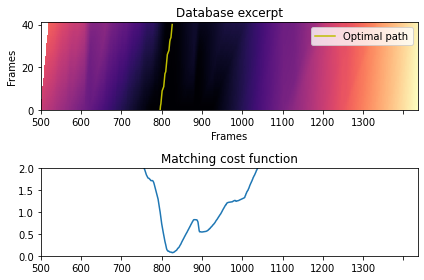

In [25]:
>>> plt.subplot(2, 1, 1)
>>> lb.display.specshow(D, x_axis='frames', y_axis='frames')
>>> plt.title('Database excerpt')
>>> plt.plot(wp[:, 1]-est_orch_start_chroma_frame, wp[:, 0], label='Optimal path', color='y')
>>> plt.xticks([i for i in range(0,D.shape[1],100)],[i for i in range(est_orch_start_chroma_frame//100*100,\
                                                                     est_orch_end_chroma_frame//100*100,100)])
>>> plt.legend()
>>> plt.subplot(2, 1, 2)
>>> plt.plot(D[-1, :] / wp.shape[0])
>>> 
>>> plt.xlim([0, D.shape[1]])
>>> plt.ylim([0, 2])
>>> plt.title('Matching cost function')
>>> plt.xticks([i for i in range(0,D.shape[1],100)],[i for i in range(est_orch_start_chroma_frame//100*100,\
                                                                     est_orch_end_chroma_frame//100*100,100)])
>>> plt.tight_layout()
>>> plt.show()

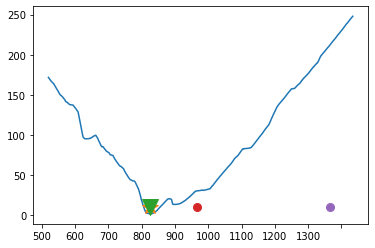

In [24]:
plt.plot(D[-1]),est_orch_start_chroma_frame, input_time_index
plt.xticks([i for i in range(0,D.shape[1],100)],[i for i in range(est_orch_start_chroma_frame//100*100,\
                                                                     est_orch_end_chroma_frame//100*100,100)])
# goal
plt.plot(input_time_index[-1]/512-est_orch_start_chroma_frame,10,marker="*", markersize=16)
# prediction
plt.plot(wp[-1,1]-est_orch_start_chroma_frame,10,marker="v", markersize=16)
plt.plot(D.shape[1]//2,10,marker=".", markersize=16)
input_time_index/512
plt.plot((est_curr_frame),10,marker=".", markersize=16)